In [ ]:
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#
#! kaggle datasets download bittlingmayer/amazonreviews

In [ ]:
#!unzip /content/amazonreviews.zip

In [ ]:
#!bunzip2 /content/train.ft.txt.bz2

In [ ]:
#!bunzip2 /content/test.ft.txt.bz2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bz2

In [ ]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    labels = labels[:int(len(labels)*0.01)]
    texts = texts[:int(len(texts)*0.01)]
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('/content/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('/content/test.ft.txt.bz2')

In [ ]:
train_df=pd.DataFrame(zip(train_texts,train_labels),columns=['text','label'])
print(train_df.head())
test_df=pd.DataFrame(zip(test_texts,test_labels),columns=['text','label'])
print(test_df.head())

                                                text  label
0  Stuning even for the non-gamer: This sound tra...      1
1  The best soundtrack ever to anything.: I'm rea...      1
2  Amazing!: This soundtrack is my favorite music...      1
3  Excellent Soundtrack: I truly like this soundt...      1
4  Remember, Pull Your Jaw Off The Floor After He...      1
                                                text  label
0  Great CD: My lovely Pat has one of the GREAT v...      1
1  One of the best game music soundtracks - for a...      1
2  Batteries died within a year ...: I bought thi...      0
3  works fine, but Maha Energy is better: Check o...      1
4  Great for the non-audiophile: Reviewed quite a...      1


In [ ]:
print(train_df.text[0])

Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


In [ ]:
import regex as re
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.regexp import RegexpStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
def remove_special_characters(text):
  text=text.str.lower()
  text=text.apply(lambda x: re.sub(r'[0-9]+','',x))
  text=text.apply(lambda x: re.sub(r'@mention',' ',x))
  text=text.apply(lambda x: re.sub(r'https?:\/\/\S+', ' ',x))
  text=text.apply(lambda x: re.sub(r"www.\[a-z]?\.?(com)+|[a-z]+\.(com)", ' ',x))
  text=text.apply(lambda x: re.sub(r"[_\,\>\(\-:\)\\\/\!\.\^\!\:\];='#]",'',x))
  return text

In [ ]:
train_df['text']=remove_special_characters(train_df['text'])
test_df['text']=remove_special_characters(test_df['text'])

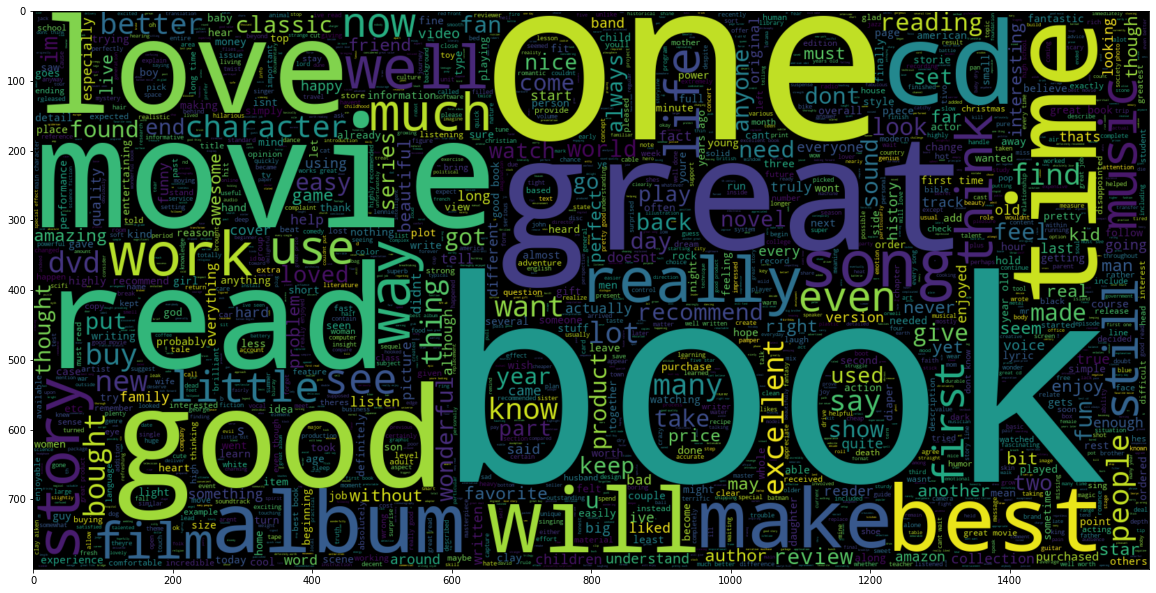

In [ ]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(train_df[train_df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

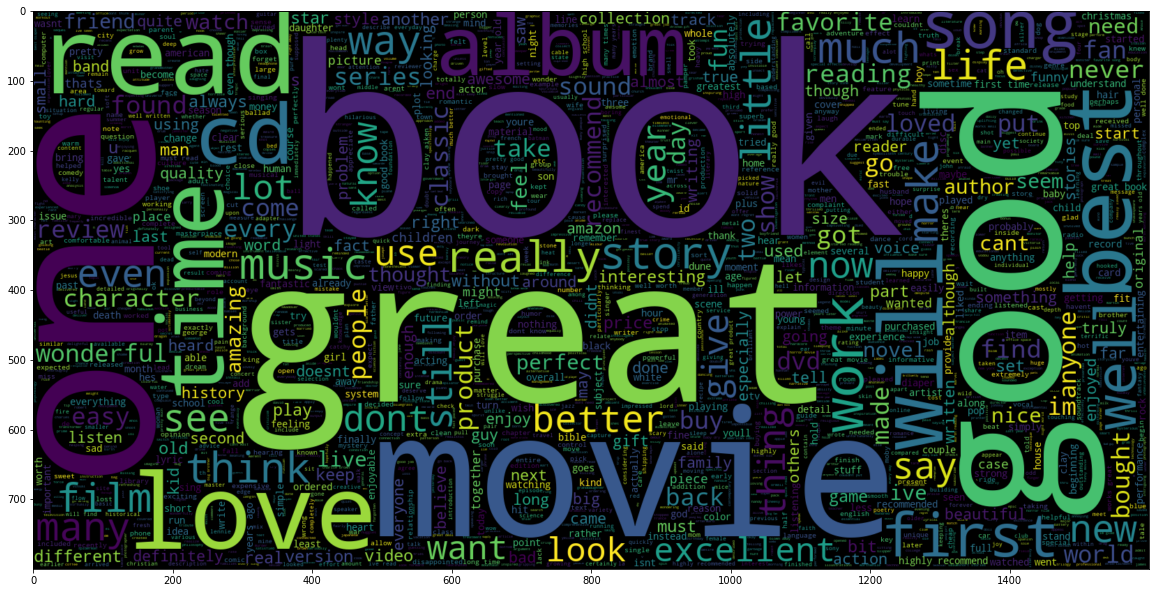

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(test_df[test_df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
#from collections import Counter
#counter = Counter(train_df['text'])
#most_common = counter.most_common(10)
#most_common = dict(most_common)
#most_common


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer

#def preprocessing(train_df,text):
#  tokenizer=TreebankWordTokenizer()
#  stemmer=SnowballStemmer(language='english')
#  token=text.apply(tokenizer.tokenize)
#  words=[[stemmer.stem(tok) for tok in tokens] for tokens in token]
#  train_df['lemm']=[' '.join(word) for word in words]
#  train_df['token']=[' '.join(tokens) for tokens in token]
#  vectorizer=TfidfVectorizer(stop_words='english',ngram_range=(1,3),min_df=3,max_features=500)
#  train_text=vectorizer.fit_transform(train_df['lemm'])
#  train_text=train_text.todense()
#  train_df=train_df.drop(['text'],axis=1)
#  train_df=train_df.drop(['token'],axis=1)
#  return train_text
#
#train_vector=preprocessing(train_df,train_df['text'])
#test_vector=preprocessing(test_df,test_df['text'])

In [ ]:
from keras.preprocessing import text,sequence

MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 86207 unique tokens.


In [ ]:
from keras_preprocessing.sequence import pad_sequences

train_text = tokenizer.texts_to_sequences(train_df['text'].values)
train_text = pad_sequences(train_text, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', train_text.shape)

y = pd.get_dummies(train_df['label']).values
print('Shape of label tensor:', y.shape)


Shape of data tensor: (36000, 250)
Shape of label tensor: (36000, 2)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_text,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(32400, 250) (32400, 2)
(3600, 250) (3600, 2)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,SpatialDropout1D
import tensorflow as tf

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=train_text.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          1000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,080,602
Trainable params: 1,080,602
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



Epoch 1/5
456/456 [==============================] - 344s 747ms/step - loss: 0.3858 - accuracy: 0.8273 - val_loss: 0.4799 - val_accuracy: 0.7877
Epoch 2/5
456/456 [==============================] - 340s 746ms/step - loss: 0.2563 - accuracy: 0.9011 - val_loss: 0.2838 - val_accuracy: 0.8861
Epoch 3/5
456/456 [==============================] - 340s 745ms/step - loss: 0.1968 - accuracy: 0.9269 - val_loss: 0.2830 - val_accuracy: 0.8920
Epoch 4/5
456/456 [==============================] - 342s 750ms/step - loss: 0.1467 - accuracy: 0.9479 - val_loss: 0.3482 - val_accuracy: 0.8898
Epoch 5/5
456/456 [==============================] - 341s 747ms/step - loss: 0.1199 - accuracy: 0.9581 - val_loss: 0.3572 - val_accuracy: 0.8867


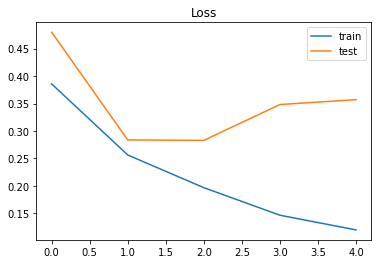

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


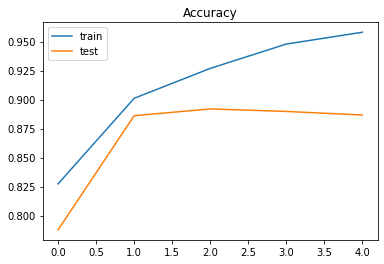

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()